In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
import pickle

In [3]:
with open('../outputs/raven_results_-40kg.pkl', 'rb') as f:
    raven_results_m40 = pickle.load(f)
with open('../outputs/raven_results_20kg.pkl', 'rb') as f:
    raven_results_20kg = pickle.load(f)
with open('../outputs/raven_results_40kg.pkl', 'rb') as f:
    raven_results_40kg = pickle.load(f)

In [4]:
def feature_importance(vec):
    # Step 2: Perform PCA
    pca = PCA()
    pca.fit(vec)
    # Step 3: Extract Feature Contributions
    # PCA components (loading matrix) shape: n_components x n_features
    loading_matrix = pca.components_

    # Variance explained by each component
    explained_variance = pca.explained_variance_ratio_

    # Step 4: Aggregate Feature Contributions (Weighted by Variance)
    # Importance of each feature is proportional to its loading * variance explained
    feature_contributions = np.sum(np.abs(loading_matrix.T) * explained_variance, axis=1)

    # Normalize contributions to sum to 1
    feature_contributions_normalized = feature_contributions / np.sum(feature_contributions)

    # Step 5: Create a DataFrame for Easy Analysis
    feature_importance_df = pd.DataFrame({
        "Feature": [f"Feature_{i}" for i in range(vec.shape[1])],
        "Contribution": feature_contributions_normalized
    }).sort_values(by="Contribution", ascending=False)

    # Display Top 10 Features
    # print(feature_importance_df.head(10))
    return feature_importance_df

In [5]:
fi_20 = feature_importance(raven_results_20kg)
fi_m40 = feature_importance(raven_results_m40)
fi_40 = feature_importance(raven_results_40kg)

In [6]:
fi_20.head(10)

,Feature,Contribution
261,Feature_261,0.010118
69,Feature_69,0.010094
154,Feature_154,0.010073
226,Feature_226,0.009854
139,Feature_139,0.009834
11,Feature_11,0.009818
50,Feature_50,0.009791
247,Feature_247,0.009768
34,Feature_34,0.009755
248,Feature_248,0.009723


In [7]:
fi_40.head(10)

,Feature,Contribution
69,Feature_69,0.009970
261,Feature_261,0.009968
154,Feature_154,0.009948
226,Feature_226,0.009711
11,Feature_11,0.009690
139,Feature_139,0.009689
247,Feature_247,0.009641
50,Feature_50,0.009636
34,Feature_34,0.009632
248,Feature_248,0.009602


In [8]:
fi_m40.head(10)

,Feature,Contribution
261,Feature_261,0.010560
69,Feature_69,0.010490
154,Feature_154,0.010476
226,Feature_226,0.010308
139,Feature_139,0.010293
50,Feature_50,0.010271
11,Feature_11,0.010248
247,Feature_247,0.010199
34,Feature_34,0.010181
248,Feature_248,0.010150


In [9]:
with open('../outputs/random_scales.pkl', 'rb') as f:
    random_scales = pickle.load(f)

In [10]:
random_scales[261], random_scales[69], random_scales[154]

(495.02791966712124, 493.4447796065986, 492.8266620098893)

In [11]:
raven_results_20kg.shape

(455, 300)

In [5]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
          'backlash1', 'backlash2',
          'lackLubrication1', 'lackLubrication2',
          'spalling1', 'spalling2', 'spalling3', 'spalling4',
          'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [6]:
all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}
num_instances = 0
for k, v in all_instances.items():
    num_instances += len(v)
    print(f"Total number of instances for {k}: {len(v)}")
print(f"Total number of instances: {num_instances}")

Total number of instances for 20kg_normal: 35
Total number of instances for 40kg_normal: 35
Total number of instances for -40kg_normal: 35
Total number of instances for 20kg_backlash1: 35
Total number of instances for 40kg_backlash1: 32
Total number of instances for -40kg_backlash1: 35
Total number of instances for 20kg_backlash2: 35
Total number of instances for 40kg_backlash2: 35
Total number of instances for -40kg_backlash2: 35
Total number of instances for 20kg_lackLubrication1: 35
Total number of instances for 40kg_lackLubrication1: 35
Total number of instances for -40kg_lackLubrication1: 35
Total number of instances for 20kg_lackLubrication2: 35
Total number of instances for 40kg_lackLubrication2: 35
Total number of instances for -40kg_lackLubrication2: 35
Total number of instances for 20kg_spalling1: 35
Total number of instances for 40kg_spalling1: 35
Total number of instances for -40kg_spalling1: 35
Total number of instances for 20kg_spalling2: 35
Total number of instances for 

In [7]:
def get_average(load_str):
    average_dict = {}
    for k, v in all_instances.items():    
        load, state = k.split('_')
        # Average all current and position error of 20kgnormal
        if load == load_str:
            all_files = all_instances[k]
            average_dict[k] = {'current': [], 'position_error': []}

            n_cur = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['current'])
            n_pos_err = len(pd.read_csv(os.path.join(INSTANCES_DIR, load, state, all_files[0]))['position_error'])

            average_df = {'current': [0] * n_cur, 'position_error': [0] * n_pos_err}

            for filename in all_files:
                df = pd.read_csv(os.path.join(INSTANCES_DIR, load, state, filename))
                average_df['current'] += df['current']
                average_df['position_error'] += df['position_error']

            average_df['current'] = average_df['current'] / len(all_files)
            average_df['position_error'] = average_df['position_error'] / len(all_files)
            
            average_dict[k]['current'] = average_df['current'].tolist()
            average_dict[k]['position_error'] = average_df['position_error'].tolist()
    return average_dict

In [8]:
average_dict_20 = get_average('20kg')
average_dict_40 = get_average('40kg')
average_dict_m40 = get_average('-40kg')

In [11]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 15))

# # Plot the first figure on the first subplot (ax1)
# ax1.set_title('Averaging current signals under different states of 20kg with savgol_filter')
# for k, v in average_dict_20.items():
#     ax1.plot(savgol_filter(v['current'], window_length=15, polyorder=2), label=k)
#     ax1.set_xlabel('Set point ()')
#     ax1.set_ylabel('Current (A)')
#     ax1.legend()

# # Plot the second figure on the second subplot (ax2)
# ax2.set_title('Averaging position error signals under different states of 20kg with savgol_filter')
# for k, v in average_dict_20.items():
#     ax2.plot(savgol_filter(v['position_error'], window_length=15, polyorder=2), label=k)
#     ax2.set_xlabel('Set point ()')
#     ax2.set_ylabel('Position error (mm)')
#     ax2.legend()

# plt.tight_layout()

# plt.show()

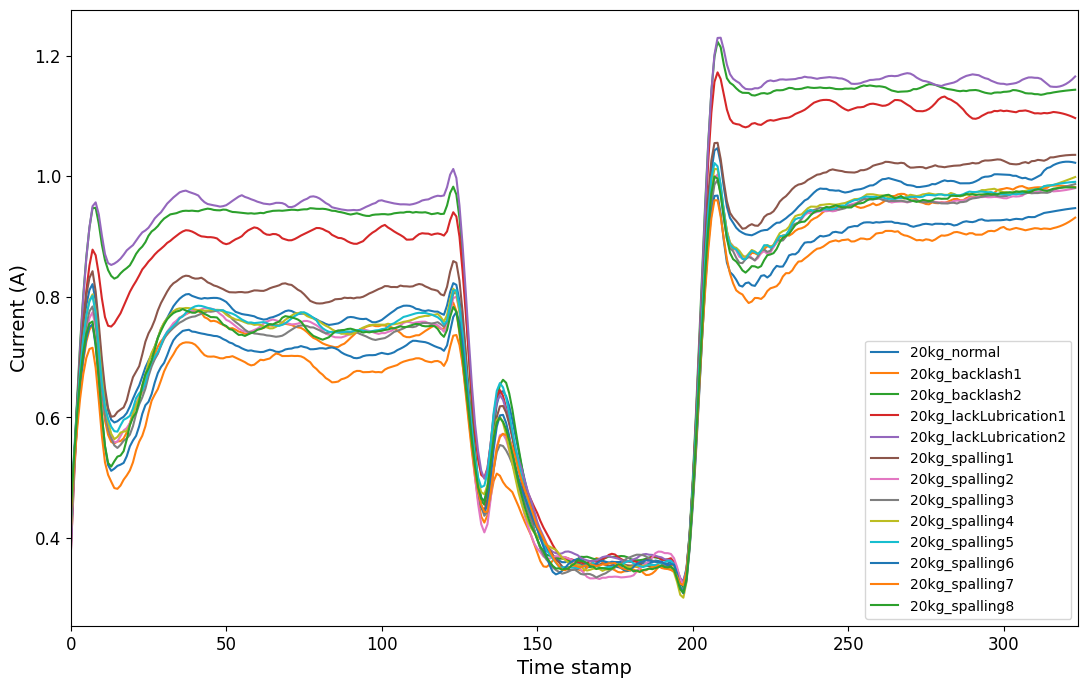

In [19]:
plt.figure(figsize=(13, 8))
# plt.title('Averaging current signals under different states of 20kg with savgol_filter')
for k, v in average_dict_20.items():
    plt.plot(savgol_filter(v['current'], window_length=15, polyorder=2), label=k)
    plt.xlabel('Time stamp', fontsize=14)
    plt.ylabel('Current (A)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.xlim(0, len(v['current']))
    plt.yticks(fontsize=12)
    plt.legend(fontsize=10)

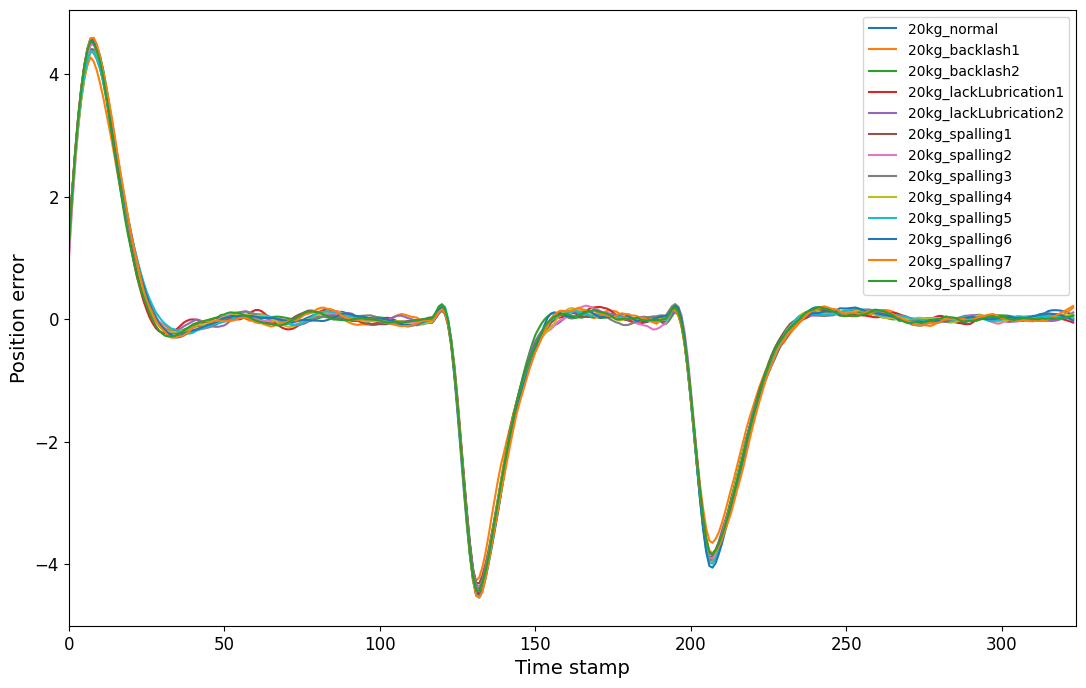

In [17]:
plt.figure(figsize=(13, 8))
# plt.title('Averaging current signals under different states of 20kg with savgol_filter')
for k, v in average_dict_20.items():
    plt.plot(savgol_filter(v['position_error'], window_length=15, polyorder=2), label=k)
    plt.xlabel('Time stamp', fontsize=14)
    plt.ylabel('Position error', fontsize=14)
    plt.xticks(fontsize=12)
    plt.xlim(0, len(v['position_error']))
    plt.yticks(fontsize=12)
    plt.legend(fontsize=10)

In [32]:
smooth_dict_20 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_20.items()}
smooth_dict_40 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_40.items()}
smooth_dict_m40 = {k:savgol_filter(v['current'], window_length=15, polyorder=2) for k, v in average_dict_m40.items()}
# smooth_dict

In [67]:
smooth_dict_20_average = {'normal': smooth_dict_20['20kg_normal'],
                        'backlash': (smooth_dict_20['20kg_backlash1'] + smooth_dict_20['20kg_backlash2']) / 2,
                        'lackLubrication': (smooth_dict_20['20kg_lackLubrication1'] + smooth_dict_20['20kg_lackLubrication2']) / 2,
                        'light_spalling': (smooth_dict_20['20kg_spalling1'] + smooth_dict_20['20kg_spalling2'] + smooth_dict_20['20kg_spalling3']) / 3,
                        'medium_spalling': (smooth_dict_20['20kg_spalling3'] + smooth_dict_20['20kg_spalling4'] + smooth_dict_20['20kg_spalling5']) / 3,
                        'heavy_spalling': (smooth_dict_20['20kg_spalling6'] + smooth_dict_20['20kg_spalling7'] + smooth_dict_20['20kg_spalling8']) / 3}

smooth_dict_40_average = {'normal': smooth_dict_40['40kg_normal'],
                        'backlash': (smooth_dict_40['40kg_backlash1'] + smooth_dict_40['40kg_backlash2']) / 2,
                        'lackLubrication': (smooth_dict_40['40kg_lackLubrication1'] + smooth_dict_40['40kg_lackLubrication2']) / 2,
                        'light_spalling': (smooth_dict_40['40kg_spalling1'] + smooth_dict_40['40kg_spalling2'] + smooth_dict_40['40kg_spalling3']) / 3,
                        'medium_spalling': (smooth_dict_40['40kg_spalling3'] + smooth_dict_40['40kg_spalling4'] + smooth_dict_40['40kg_spalling5']) / 3,
                        'heavy_spalling': (smooth_dict_40['40kg_spalling6'] + smooth_dict_40['40kg_spalling7'] + smooth_dict_40['40kg_spalling8']) / 3}

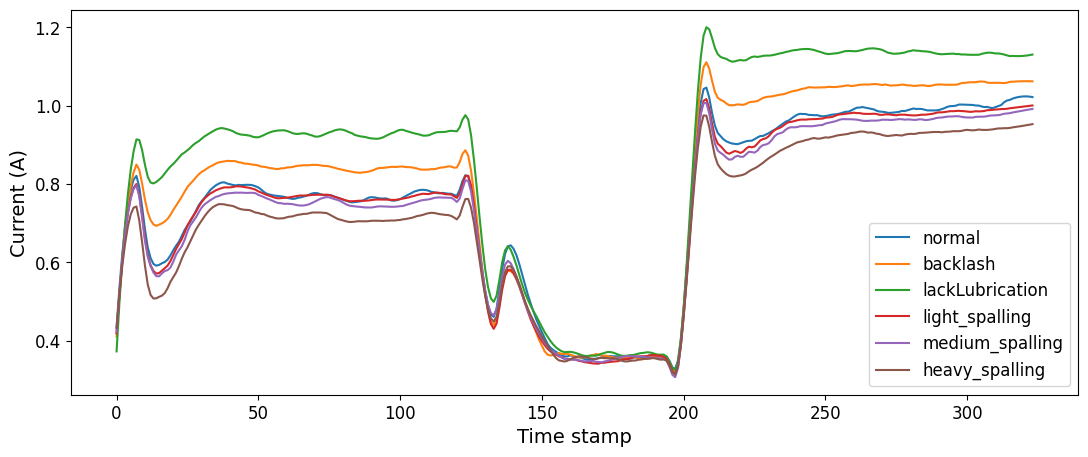

In [96]:
plt.figure(figsize=(13, 5))
for k, v in smooth_dict_20_average.items():
    plt.plot(v, label=k)
    plt.xlabel('Time stamp', fontsize=14)
    plt.ylabel('Current (A)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
plt.show()

In [69]:
import pywt

coeffs_dict_20_lf = {k: pywt.cwt(v, 5, 'morl', method='conv')[0][0] for k, v in smooth_dict_20_average.items()}
coeffs_dict_40_lf = {k: pywt.cwt(v, 5, 'morl', method='conv')[0][0] for k, v in smooth_dict_40_average.items()}

coeffs_dict_20_mf = {k: pywt.cwt(v, 50, 'morl', method='conv')[0][0] for k, v in smooth_dict_20_average.items()}
coeffs_dict_40_mf = {k: pywt.cwt(v, 50, 'morl', method='conv')[0][0] for k, v in smooth_dict_40_average.items()}

coeffs_dict_20_hf = {k: pywt.cwt(v, 500, 'morl', method='conv')[0][0] for k, v in smooth_dict_20_average.items()}
coeffs_dict_40_hf = {k: pywt.cwt(v, 500, 'morl', method='conv')[0][0] for k, v in smooth_dict_40_average.items()}
# coeffs_dict_m40 = {k: pywt.cwt(v, 495, 'morl', method='conv')[0][0] for k, v in smooth_dict_m40.items()}

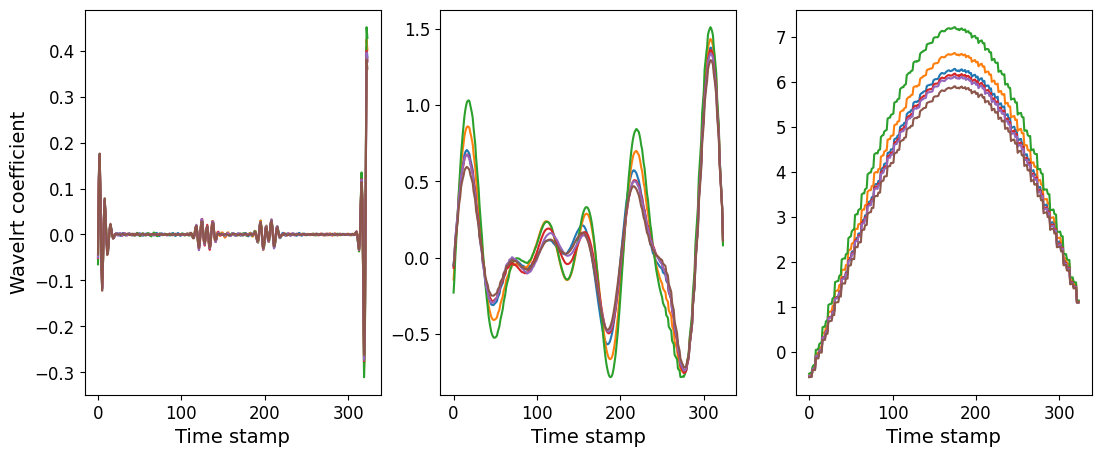

In [97]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
for k, v in coeffs_dict_20_lf.items():
    plt.plot(v, label=k)
    
plt.xlabel('Time stamp', fontsize=14)
plt.ylabel('Wavelrt coefficient', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 3, 2)
for k, v in coeffs_dict_20_mf.items():
    plt.plot(v, label=k)

plt.xlabel('Time stamp', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 3, 3)
for k, v in coeffs_dict_20_hf.items():
    plt.plot(v, label=k)

plt.xlabel('Time stamp', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# plt.figure(figsize=(5, 5))
# for k, v in coeffs_dict_40.items():
#     plt.plot(v, label=k)
#     # plt.legend()
# plt.show()

# plt.figure(figsize=(5, 5))
# for k, v in coeffs_dict_m40.items():
#     plt.plot(v, label=k)
#     # plt.legend()
# plt.axvline(x=125, color='red', linestyle='--')
# plt.show()

In [71]:
indicator_dict_20 = {k: np.trapz(v) for k, v in coeffs_dict_20_hf.items()}
indicator_dict_40 = {k: np.trapz(v) for k, v in coeffs_dict_40_hf.items()}
indicator_dict_20

{'normal': 1289.5375106121041,
 'backlash': 1365.297871854722,
 'lackLubrication': 1485.7423946981003,
 'light_spalling': 1268.2490902154848,
 'medium_spalling': 1254.9112582265748,
 'heavy_spalling': 1208.5141567421801}

In [72]:
# indicator_dict_20 = {k: v[175] for k, v in coeffs_dict_20_hf.items()}
# indicator_dict_40 = {k: v[175] for k, v in coeffs_dict_40_hf.items()}
# indicator_dict_m40 = {k: v[125] for k, v in coeffs_dict_m40.items()}

In [73]:
sorted_dict_20 = dict(sorted(indicator_dict_20.items(), key=lambda item: item[1], reverse=True))
sorted_dict_40 = dict(sorted(indicator_dict_40.items(), key=lambda item: item[1], reverse=True))
# sorted_dict_m40 = dict(sorted(indicator_dict_m40_refined.items(), key=lambda item: item[1], reverse=True))
sorted_dict_20

{'lackLubrication': 1485.7423946981003,
 'backlash': 1365.297871854722,
 'normal': 1289.5375106121041,
 'light_spalling': 1268.2490902154848,
 'medium_spalling': 1254.9112582265748,
 'heavy_spalling': 1208.5141567421801}

In [75]:
sorted_dict_40

{'lackLubrication': 1499.1218880534338,
 'backlash': 1425.7746032511275,
 'normal': 1318.2553196401884,
 'light_spalling': 1298.599128102519,
 'medium_spalling': 1287.5085868139292,
 'heavy_spalling': 1208.7130037571355}

In [77]:
# linear interpolation like the 37 between the 20 and 40
inter = 37
predicted_dict = {key: (sorted_dict_20[key] + (inter - 20) * (sorted_dict_40[key] - sorted_dict_20[key]) / (40 - 20)) for key in sorted_dict_20.keys()}
predicted_dict

{'lackLubrication': 1497.1149640501337,
 'backlash': 1416.7030935416667,
 'normal': 1313.9476482859757,
 'light_spalling': 1294.0466224194638,
 'medium_spalling': 1282.618987525826,
 'heavy_spalling': 1208.6831767048923}

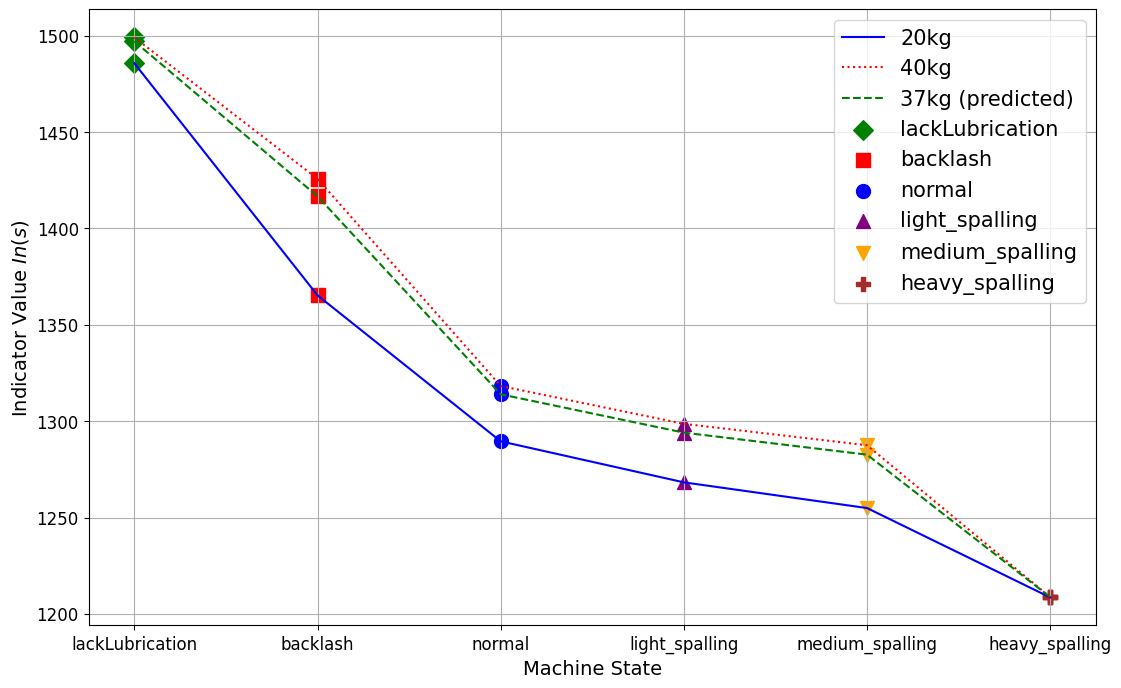

In [103]:
# Extract keys and values
keys_20 = list(sorted_dict_20.keys())
values_20 = list(sorted_dict_20.values())

keys_40 = list(sorted_dict_40.keys())
values_40 = list(sorted_dict_40.values())

keys_inter= list(predicted_dict.keys())
values_inter = list(predicted_dict.values())

states_labels = ['lackLubrication', 'backlash', 'normal', 'light_spalling', 'medium_spalling', 'heavy_spalling']
markers = {'normal': 'o', 'backlash': 's', 'lackLubrication': 'D', 'light_spalling': '^', 'medium_spalling': 'v', 'heavy_spalling': 'P'}
colors = {'normal': 'blue', 'backlash': 'red', 'lackLubrication': 'green', 'light_spalling': 'purple', 'medium_spalling': 'orange', 'heavy_spalling': 'brown'}

# Plot the curve
plt.figure(figsize=(13, 8))
plt.plot(values_20, label='20kg', linestyle='-', color='b')
plt.plot(values_40, label='40kg', linestyle=':', color='r')
plt.plot(values_inter, label='37kg (predicted)', linestyle='--', color='g')


for i, (key, value) in enumerate(zip(keys_20, values_20)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)
for i, (key, value) in enumerate(zip(keys_40, values_40)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)
for i, (key, value) in enumerate(zip(keys_inter, values_inter)):
    plt.scatter(i, value, marker=markers[key], color=colors[key], label=key, s=100)

# Creating a custom legend with unique handles
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=15)

# Add title and labels
# plt.title('Values in Sorted Dictionary with Clear Labels')
plt.xlabel('Machine State', fontsize=14)
plt.ylabel('Indicator Value ' + r'$In(s)$', fontsize=14)
plt.xticks(ticks=list(range(len(states_labels))), labels=states_labels, fontsize=12)
plt.yticks(fontsize=12)

# Display plot
plt.grid(True)
plt.show()